In [539]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image, ImageFilter

from matplotlib import pyplot as plt

# Preparing and Loading the Data 
## The MNIST dataset is structured as follows:

    - 785 columns
    - First column = class_label
    - Each column after represents one pixel value (784 total for a 28 x 28 image)

In [579]:
# Data parameters
train_path = './data/emnist-balanced-train.csv'
test_path = './data/emnist-balanced-test.csv'

classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'#47 classes. Not including some of the lower-case letters because 
                                                           #their capital letter and lower-case letter are the same.

## By default the EMNIST images are flipped.
### Using a function to pre-process the data to be ready for the classifier.

In [2]:
num_classes = 47 
img_size = 28

def img_label_load(data_path, num_classes=None):
    data = pd.read_csv(data_path, header=None)
    data_rows = len(data)
    
    if not num_classes:
        num_classes = len(data[0].unique())
    
    # Assuming 28x28 images
    img_size = int(np.sqrt(len(data.iloc[0][1:])))
    
    imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3])
    
    labels = keras.utils.to_categorical(data.values[:,0], num_classes) # one-hot encoding vectors
    
    return imgs/255., labels

In [3]:
## Convert One-Hot-Encoded values back to real values
def decode_label(binary_encoded_label):
    return np.argmax(binary_encoded_label)

In [4]:
## Plot the image with it's correct value
def show_img(img,label):
    plt.title('Label: ' + str(classes[decode_label(label)]))
    plt.imshow(img, cmap='Greys_r')  #-1 here if we have skipped the first row

# Model evaluation function

In [583]:
## Evaluate model with the test dataset
def evaluate_model(model,x_test,y_test):
    result = model.evaluate(x_test, y_test)
    print("The accuracy of the model is: ",result[1])
    return result

## Plotting function

In [584]:
## Plot the training history
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    #Plot training loss and accuracy
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    
    #Plot validation loss and accuracy
    plt.plot(epochs, acc, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
    
    plt.title('Validation accuracy and training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    

    plt.show()

## Reading train data

In [585]:
x_train, y_train = img_label_load(train_path)

In [586]:
print(x_train.shape)
y_train.shape

(112800, 28, 28, 1)


(112800, 47)

## Checking what the data looks like

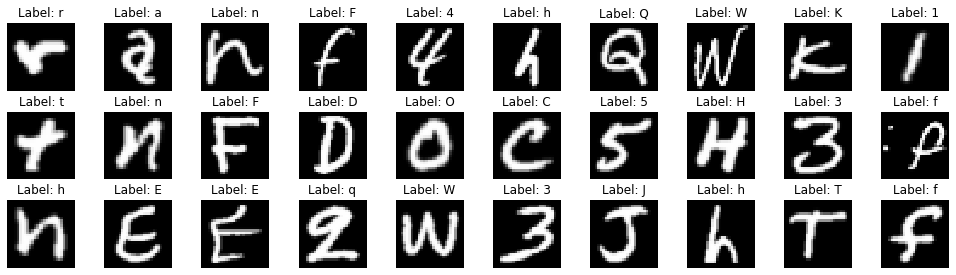

In [587]:
fig = plt.figure(figsize=(17,4.5))
for i in range(30):
    
    fig.add_subplot(3,10,i+1)
    plt.axis('off')
    show_img(np.squeeze(x_train[i]),y_train[i])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Creating the model architecture

In [588]:
def create_model(input_size, output_size):
    model = Sequential()

    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (input_size[0], input_size[1], input_size[2])))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

## Training the model

In [590]:
batch_size = 64

model = create_model([img_size, img_size,1],len(classes))
model.summary()
history = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = 15,
          validation_split = 0.1)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_23 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 32)       

# Plotting the accuracy and loss of the model

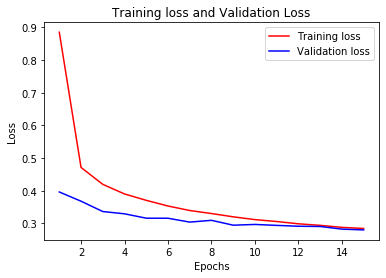

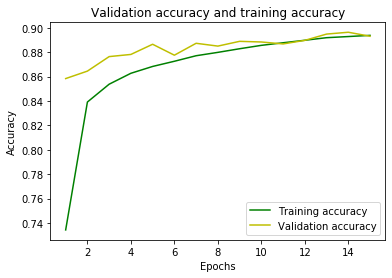

In [591]:
plot_history(history)

## Running evaluation on the model

In [592]:
x_test, y_test = img_label_load(test_path)
print(x_test.shape)
print(y_test.shape)

(18800, 28, 28, 1)
(18800, 47)


In [594]:
evaluate_model(model, x_test, y_test)

18800/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The accuracy of the model is:  0.8976596


[0.2903212129562459, 0.8976596]

## Saving the model

In [595]:
model.save('./models/letters_and_digits_89.h5')

## Adding data augmentation.

In [596]:
data_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)

data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(validation_split=.2,
                                            width_shift_range=.2, height_shift_range=.2,
                                            rotation_range=20, zoom_range=.2, shear_range=.3)

model_with_aug = create_model([img_size, img_size,1],len(classes))

training_data_generator = data_generator.flow(x_train, y_train, subset='training')
validation_data_generator = data_generator.flow(x_train, y_train, subset='validation')
history_augmented = model_with_aug.fit_generator(training_data_generator, 
                              steps_per_epoch=1024, epochs=10,
                              validation_data=validation_data_generator)

Epoch 1/10
1024/1024 [==============================] - 78s 77ms/step - loss: 1.3390 - accuracy: 0.6247 - val_loss: 0.5285 - val_accuracy: 0.8257
Epoch 2/10
1024/1024 [==============================] - 76s 75ms/step - loss: 0.6534 - accuracy: 0.7847 - val_loss: 0.4843 - val_accuracy: 0.8374
Epoch 3/10
1024/1024 [==============================] - 76s 74ms/step - loss: 0.5539 - accuracy: 0.8138 - val_loss: 0.4140 - val_accuracy: 0.8593
Epoch 4/10
1024/1024 [==============================] - 77s 75ms/step - loss: 0.5088 - accuracy: 0.8272 - val_loss: 0.3891 - val_accuracy: 0.8651
Epoch 5/10
1024/1024 [==============================] - 78s 76ms/step - loss: 0.4912 - accuracy: 0.8311 - val_loss: 0.3977 - val_accuracy: 0.8617
Epoch 6/10
1024/1024 [==============================] - 77s 75ms/step - loss: 0.4591 - accuracy: 0.8418 - val_loss: 0.3679 - val_accuracy: 0.8664
Epoch 7/10
1024/1024 [==============================] - 77s 75ms/step - loss: 0.4423 - accuracy: 0.8467 - val_loss: 0.3526 -

# Plotting the accuracy and loss of the model with augmentation

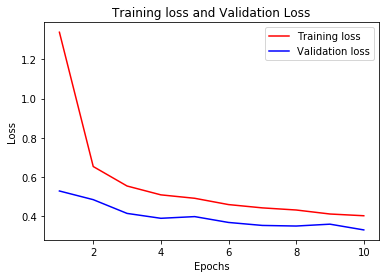

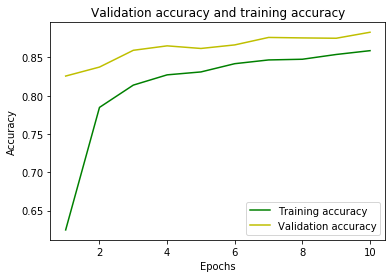

In [597]:
plot_history(history_augmented)

## Running evaluation on the model with augmentation

In [598]:
x_test, x_test = img_label_load(test_path)
test_data_generator = data_generator.flow(x_train, y_train)

model.evaluate_generator(test_data_generator)

[0.21420181303265248, 0.91664004]

# Saving the model with augmentation

In [599]:
model.save('./models/letters_and_digits_91_augmentation.h5')

# Testing the classifier on image taken by me

In [954]:
def run_prediction(img, model):
    result = np.argmax(model.predict(img))
    confidence = max(model.predict(img)[0])
    return result, confidence

In [955]:
def image_to_emnist(img):
    img = img.resize((28, 28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
    
    img_canvas = Image.new('L', (28, 28), (255))
    img_canvas.paste(img)
    
    img_data = list(img_canvas.getdata())

    #Normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    img_normalized = [(255 - x) * 1.0 / 255.0 for x in img_data]
    
    return img_normalized

In [972]:
imgPath = './sample-images/a.jpg'

In [973]:
img = Image.open(imgPath)

img_emnist = np.array(image_to_emnist(img)).reshape(1,28,28,1)

In [974]:
result, confidence = run_prediction(img_emnist, model)
print(result, confidence)

36 0.5146539


Prediction: a , Confidence: 0.5146539


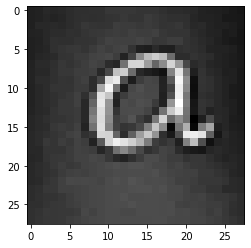

In [975]:
plt.imshow(img_emnist.reshape(28,28), cmap='Greys_r')
print('Prediction:', classes[result], ', Confidence:', confidence)